In [1]:
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(1)

In [2]:
keywords = pd.read_csv('keywords_preprocessed.csv')
meta = pd.read_csv('movies_metadata_preprocessed.csv')
ratings = pd.read_csv('ratings_preprocessed.csv')

In [3]:
#random_state in the train test split has been set to 1 to recreate results, remove it to review model
df_numeric = meta[['budget','popularity','revenue','runtime','vote_average','vote_count']]
df_numeric.dropna(inplace=True)
#new feature "new" has been engineered to be able to use the votes provided by viewers while trying to 
#give importance to number of voters
df_numeric['new'] = df_numeric['vote_average']*np.power(df_numeric['vote_count'],0.8)
train,test = train_test_split(df_numeric,test_size=0.25,random_state = 1)

/Users/rahulshiv/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/rahulshiv/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [4]:
x = train.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = df_numeric.columns

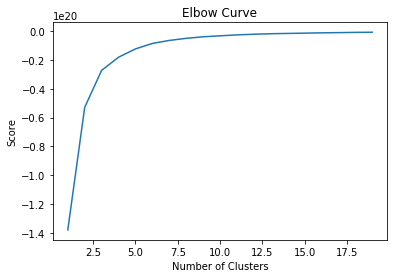

In [5]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
y = np.array(train.revenue).reshape(-1,1)
score = [kmeans[i].fit(y).score(y) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [6]:
#we look at the graph and not that elbow is at 4 and hence we choose 4 as
kmeans = KMeans(n_clusters=4)
pred = kmeans.fit(y).predict(y)
train['cluster'] = kmeans.labels_


/Users/rahulshiv/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [7]:
print('Size of clusters : ',[len(train[train.cluster==i]) for i in range(4)])

Size of clusters :  [31385, 300, 1240, 75]


In [8]:
train.groupby(['cluster']).mean()

,budget,popularity,revenue,runtime,vote_average,vote_count,new
cluster,,,,,,,
0,5.433583e+06,2.462828,9.070498e+06,93.622973,5.605420,46.572790,107.434876
1,9.166186e+07,16.558969,3.796306e+08,117.426667,6.589667,2500.530000,3423.160379
2,4.341587e+07,10.930461,1.238808e+08,119.984677,6.324435,881.073387,1380.460633
3,1.621867e+08,50.661106,9.431160e+08,132.893333,6.982667,5598.280000,6990.790071


In [ ]:
size_array = list(train.groupby(['cluster']).count()['revenue'].values)
train[train['cluster']==size_array.index(sorted(size_array)[0])].revenue.mean()
for i in train.iloc[:,:-1]:
    plt.scatter(train[i],train['revenue'],c=kmeans.labels_)
    plt.xlabel("Revenue")
    plt.ylabel(i)
    plt.title('Revenue vs '+i)
    plt.show()

In [ ]:
cluster1 = train[train.cluster==0]
cluster1 = cluster1[cluster1.revenue!=0]
print('Size of cluster 1: ',len(cluster1))

In [ ]:
#we can observe clusters in the train and test dataset
test_clusters = kmeans.predict(test.revenue.values.reshape(-1,1))
test['cluster'] = test_clusters
print(train.groupby(['cluster']).mean())
print(test.groupby(['cluster']).mean())

In [ ]:
#Linear regression done on selected attributes
from sklearn import linear_model
from sklearn.metrics import mean_squared_error


X = train[['budget','popularity','new']]
y = train[['revenue']]

lm = linear_model.LinearRegression()
model = lm.fit(X,y)
predictions = lm.predict(X)
pred = pd.DataFrame(predictions,columns=["revenue"])
y['revenue_pred'] = predictions

print((mean_squared_error(y.revenue,y.revenue_pred))**0.5)


residuals = y.revenue - y.revenue_pred
plt.scatter(y.revenue,y.revenue_pred,c=kmeans.labels_)
plt.xlabel("Actuals Revenue")
plt.ylabel("Predicted Revenue")
plt.show()
plt.scatter(y.revenue_pred,residuals,c=kmeans.labels_)
plt.xlabel("Residuals")
plt.ylabel("Predicted")
plt.show()

print(model.score(X,y.revenue))